In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [3]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 12
control_energy_reg = 0#1e-3#1e-6 ### regularization on maximum control energy
u_max = 1000 # does not do anything currently
thres = 0.1#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [4]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [5]:
from densities import uniform_rect_regions as pdf
import functools
region  = np.array([[[0, 0.3], [0, 0.3]],
                    [[0.6, 0.9], [0.7, 0.9]]])
region  = np.array([[[0, 1.], [0, 1.]]])
custom_pdf = functools.partial(pdf, regions=region)

In [8]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 1000)


calulcated sigma: 0.05


torch.Size([256, 12, 12])
model: tensor([[[1.3888e-09, 7.4517e-06, 2.7190e-03,  ..., 5.5065e-04,
          3.7483e-07, 1.0341e-11],
         [9.5174e-08, 1.6365e-04, 1.6510e-02,  ..., 1.0545e-04,
          7.1778e-08, 1.9803e-12],
         [1.3772e-06, 1.2992e-03, 5.3741e-02,  ..., 7.4047e-07,
          5.0404e-10, 1.3906e-14],
         ...,
         [2.1896e-35, 1.5034e-32, 3.7860e-31,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.8026e-45, 2.3304e-42, 5.8651e-41,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9596e-15,
          5.6386e-13, 2.9445e-12],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9577e-10,
          2.7879e-08, 1.4558e-07],
         [0.0000e+00, 0.0000e+00, 1.5414e-43,  ..., 3.8701e-07,
          5.5111e-05, 2.8779e-04],
         ...,
         [5.0269e-15, 5.2268e-10, 2.4599e-06, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


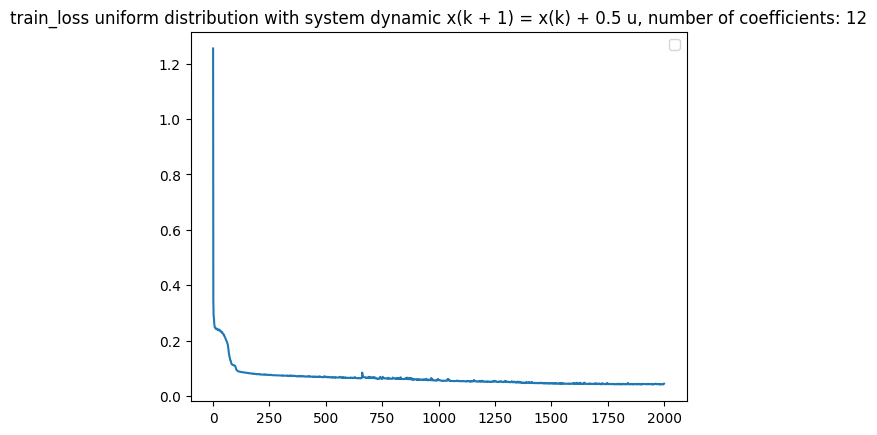

Training Complete!


In [9]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 2000  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    if avg_loss < 0.011 and not decreased:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    print() 
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [10]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)
#print(criterion.c)

torch.Size([1, 12, 12])
model: tensor([[[4.4532e-05, 5.3139e-04, 5.3391e-04, 1.0301e-02, 1.3498e-02,
          1.3545e-02, 1.0280e-02, 7.6361e-03, 9.4171e-03, 1.9931e-03,
          1.1646e-03, 3.2596e-05],
         [1.4946e-03, 1.7818e-02, 8.2577e-03, 1.6094e-02, 2.1032e-02,
          2.1376e-02, 1.6468e-02, 1.9594e-02, 2.5411e-02, 2.2993e-02,
          1.7315e-02, 9.0556e-04],
         [2.3267e-03, 2.2545e-02, 1.0259e-02, 1.3706e-02, 1.9701e-02,
          1.9715e-02, 1.5742e-02, 2.0945e-02, 2.5430e-02, 1.4232e-02,
          3.0879e-02, 9.9014e-03],
         [1.3171e-02, 1.8116e-02, 1.4931e-02, 1.9748e-02, 1.7621e-02,
          1.5908e-02, 1.4324e-02, 3.3729e-02, 2.0937e-02, 3.0100e-03,
          1.8410e-02, 7.7687e-03],
         [1.3115e-02, 1.7751e-02, 2.3335e-02, 1.4695e-02, 1.4288e-02,
          1.4140e-02, 2.1892e-03, 1.5228e-02, 2.1288e-02, 1.7488e-02,
          2.2813e-02, 8.2193e-03],
         [1.0485e-02, 1.5517e-02, 1.4645e-02, 1.1093e-02, 1.5798e-02,
          1.6319e-02, 1.

tensor(0.0414, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


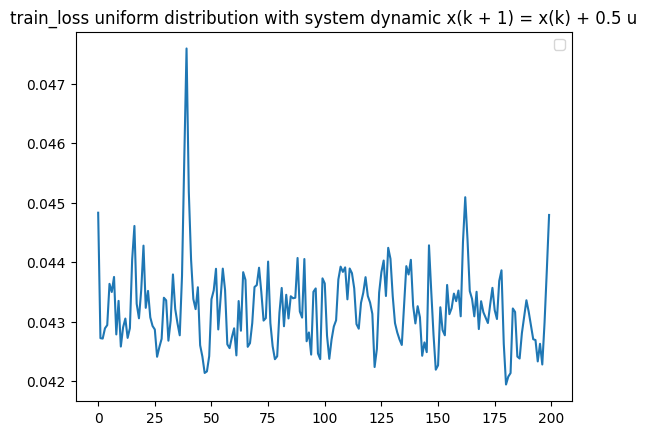

Training Complete!


In [12]:
plt.plot(train_loss[-200:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

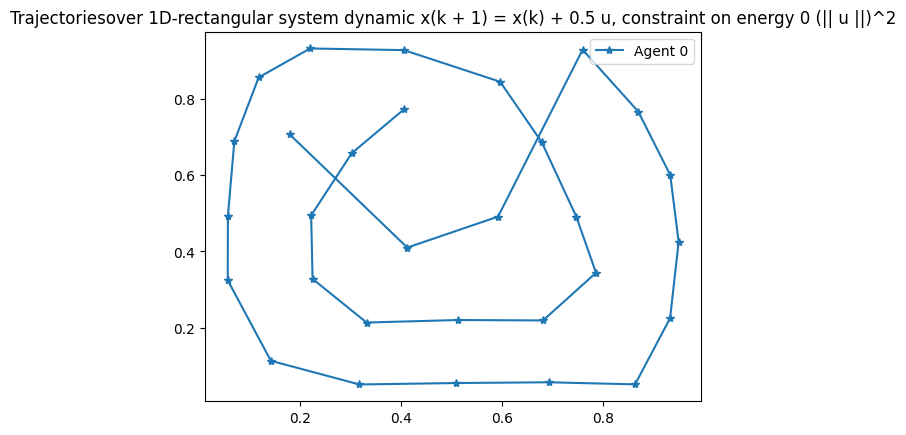

torch.Size([1, 12, 12])
model: tensor([[[4.4240e-05, 5.2626e-04, 5.3064e-04, 1.0286e-02, 1.3472e-02,
          1.3497e-02, 1.0242e-02, 7.6157e-03, 9.4146e-03, 1.9874e-03,
          1.1573e-03, 3.2349e-05],
         [1.4948e-03, 1.7764e-02, 8.2108e-03, 1.6112e-02, 2.1050e-02,
          2.1420e-02, 1.6501e-02, 2.0806e-02, 2.9952e-02, 2.3458e-02,
          1.7281e-02, 9.0378e-04],
         [2.3358e-03, 2.2621e-02, 1.0264e-02, 1.3700e-02, 1.9710e-02,
          1.9716e-02, 1.5457e-02, 1.6213e-02, 3.3726e-02, 1.5943e-02,
          3.0890e-02, 9.9056e-03],
         [1.3149e-02, 1.8072e-02, 1.4931e-02, 1.9736e-02, 1.7634e-02,
          1.5911e-02, 1.4143e-02, 2.8214e-02, 1.6399e-02, 3.0240e-03,
          1.8420e-02, 7.7794e-03],
         [1.3161e-02, 1.7785e-02, 2.3341e-02, 1.4685e-02, 1.4303e-02,
          1.4310e-02, 2.1963e-03, 1.5109e-02, 2.1167e-02, 1.7493e-02,
          2.2850e-02, 8.2259e-03],
         [1.0464e-02, 1.5538e-02, 1.4655e-02, 1.1078e-02, 1.5622e-02,
          1.6332e-02, 1.

tensor(0.0414, grad_fn=<AddBackward0>)

In [25]:
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)


In [ ]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_region_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_region_0-0.3.0.6-0.9_multiple_Agents2ae12203.pth


In [ ]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

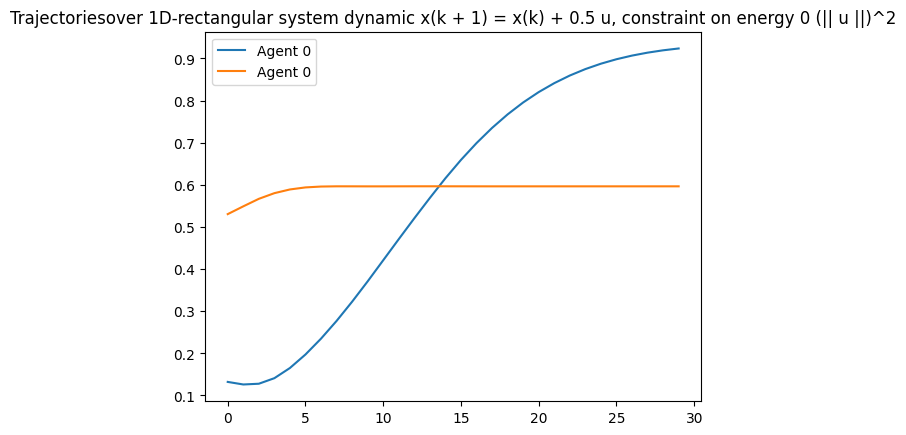

torch.Size([1, 32, 32])
model: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<CopySlices>) target: tensor([[0.0009, 0.0106, 0.0285,  ..., 0.0235, 0.0246, 0.0076],
        [0.0168, 0.0254, 0.0515,  ..., 0.0393, 0.0489, 0.0301],
        [0.0312, 0.0515, 0.0452,  ..., 0.0765, 0.0562, 0.0309],
        ...,
        [0.0015, 0.0353, 0.0389,  ..., 0.0442, 0.0612, 0.0065],
        [0.0122, 0.0407, 0.0537,  ..., 0.0188, 0.0660, 0.0069],
        [0.0004, 0.0136, 0.0101,  ..., 0.0342, 0.0046, 0.0160]])


tensor(0.0313, grad_fn=<AddBackward0>)

In [ ]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)